In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

from torch.utils.data import random_split, DataLoader
from torchvision import transforms, datasets
from torchvision.models.inception import Inception3

import os

In [25]:
%matplotlib inline

In [98]:
# Used for visualizing test data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [26]:
valid_split = 0.2
test_split = 0.2

# Resizing down for efficiency
image_size = (65, 65)

initial_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root='garbage_dataset/garbage_images', transform=initial_transforms)
valid_size = int(0.2 * len(dataset))
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - valid_size - test_size

train_set, valid_set, test_set = random_split(dataset, [train_size, valid_size, test_size])

In [27]:
# Calculate mean and std of training set
data_r = np.dstack([np.array(train_set[i][0])[0, :, :] for i in range(len(train_set))])  
data_g = np.dstack([np.array(train_set[i][0])[1, :, :] for i in range(len(train_set))])    
data_b = np.dstack([np.array(train_set[i][0])[2, :, :] for i in range(len(train_set))])    

mean_train = (np.mean(data_r), np.mean(data_g), np.mean(data_b))
std_train = (np.std(data_r), np.std(data_g), np.std(data_b))

In [38]:
# Data preprocessing
data_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_train, std=std_train)
])

dataset = datasets.ImageFolder(root='garbage_dataset/garbage_images', transform=data_transform)
valid_size = int(0.2 * len(dataset))
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - valid_size - test_size

train_set, valid_set, test_set = random_split(dataset, [train_size, valid_size, test_size])


batch_size = 64


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)


In [29]:
def train(model, optimizer, epochs=1, print_every=10):
    for e in range(epochs):
        print("Epoch: %d" % e)
        print("---------------")
        for t, (x, y) in enumerate(train_loader):
            model.train() 
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(valid_loader, model)
                print()

In [30]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [31]:
# Flatten for fully connected layers
def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1)  

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [39]:
c_1 = 32
c_2 = 64
c_3 = 64
c_4 = 32
learning_rate = 5e-4

h_1 = 500

model = nn.Sequential(
    nn.Conv2d(3, c_1, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.Conv2d(c_1, c_2, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.Conv2d(c_2, c_3, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1, padding=1),
    nn.Conv2d(c_3, c_4, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3, stride=1, padding=1),
    Flatten(),
    nn.Linear(17*17*c_4, h_1),
    nn.Linear(h_1, 10)

)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, optimizer, epochs=15, print_every=20)

Epoch: 0
---------------
Iteration 0, loss = 2.3067
Got 134 / 505 correct (26.53)

Iteration 20, loss = 1.7588
Got 213 / 505 correct (42.18)

Epoch: 1
---------------
Iteration 0, loss = 1.4543
Got 186 / 505 correct (36.83)

Iteration 20, loss = 1.3469
Got 220 / 505 correct (43.56)

Epoch: 2
---------------
Iteration 0, loss = 1.2656
Got 287 / 505 correct (56.83)

Iteration 20, loss = 1.2381
Got 300 / 505 correct (59.41)

Epoch: 3
---------------
Iteration 0, loss = 1.0950
Got 296 / 505 correct (58.61)

Iteration 20, loss = 1.0713
Got 311 / 505 correct (61.58)

Epoch: 4
---------------
Iteration 0, loss = 0.8572
Got 314 / 505 correct (62.18)

Iteration 20, loss = 0.8957
Got 299 / 505 correct (59.21)

Epoch: 5
---------------
Iteration 0, loss = 0.8544
Got 323 / 505 correct (63.96)

Iteration 20, loss = 0.6644
Got 325 / 505 correct (64.36)

Epoch: 6
---------------
Iteration 0, loss = 0.7122
Got 333 / 505 correct (65.94)

Iteration 20, loss = 0.6246
Got 362 / 505 correct (71.68)

Epoch:

In [75]:
# Evaluate model on test data
best_model = model
print("Test accuracy:")
print("------------------")
check_accuracy(test_loader, best_model)

Test accuracy:
------------------
Got 356 / 505 correct (70.50)


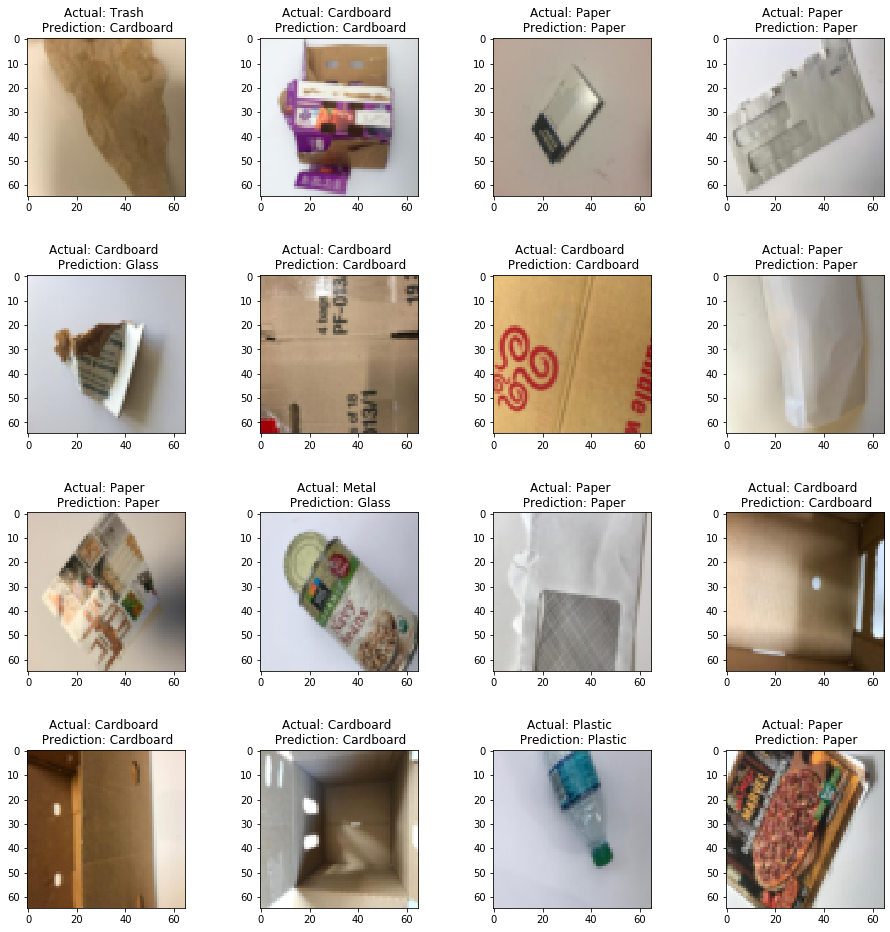

In [106]:
# Pick a random test batch to view results
test_batch, true_labels = next(iter(test_loader))

labels = ["Cardboard", "Glass", "Metal", "Paper", "Plastic", "Trash"]

scores = model(test_batch)
_, preds = scores.max(1)

unorm = UnNormalize(mean=mean_train, std=std_train) 


fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=.5)

for i in range(16):
    plt.subplot(4, 4, i+1)
    sample = test_batch[i]
    sample = unorm(sample)
    sample = transforms.ToPILImage()(sample)
    
    plt.title('Actual: %s \n Prediction: %s' % (labels[true_labels[i]], labels[preds[i]]))
    plt.imshow(sample)
